# EC1B1 Cousework

LSE EC1B1 - Microeconomics (2024/25)

**Given country:** France

**Group number:** 1

**Date**: 22/03/25

**Authors**: Amelia Dunn, Rachel Anderson, Haniah Salad, Clara Magryous

**Objectives**:
1. Clean and visualise data from France and the US showing select macroeconomic variables to investigate the Bretton Woods system.
2. Clean and visualise data from Germany and the UK showing select macroeconomic variables to investigate the UK joining and leaving the ERM.

**Repository structure:**
This shows how to build your respository so that the code runs. This file should be saved in the `code` folder as shown below. 

```
Macro/
│
├── code/
│   ├── coursework.ipynb
│
├── data/
│   ├── ... # Files with datasets
│
└── figures/
    └── ... # Figures referenced in notebooks

```



In [179]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import sys


In [180]:
sys.stderr = open(os.devnull, "w")

## 4.2. Cleaning the data

In [181]:
# Dropbox file links
us_url = "https://www.dropbox.com/scl/fi/7ujbvy5zhj9pcucnhvtrf/International_Financial_Statistics_-1.xlsx?rlkey=i0n7b9tr80217mpb760el0xtq&st=t0rba6sd&dl=1"
france_url = "https://www.dropbox.com/scl/fi/rtr775j5hclqa6an6vzmm/International_Financial_Statistics_.xlsx?rlkey=9ukpgmoemq07cfucg3f11drow&st=2gj4w8th&dl=1"

In [182]:
# Read the Excel files without headers
usdf = pd.read_excel(us_url, header=1)
frdf = pd.read_excel(france_url, header=1)

# Set the second column (Indicators) as index, remove the first column (Country name)
usdf = usdf.set_index(usdf.columns[1]).drop(columns=usdf.columns[0])
frdf = frdf.set_index(frdf.columns[1]).drop(columns=frdf.columns[0])

# Transpose the tables
usdf = usdf.T
frdf = frdf.T

# Convert index to datetime to maintain chronological order
usdf.index = pd.to_datetime(usdf.index, format="%b %Y", errors="coerce")
frdf.index = pd.to_datetime(frdf.index, format="%b %Y", errors="coerce")

Renaming some variables:

In [183]:
rename_dict = {
    "Economic Activity, Industrial Production, Index": "Industrial_Production_Index",
    "Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate": "Exchange_Rate",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International_Reserves",
    "Prices, Consumer Price Index, All items, Index": "CPI_Index"
}

usdf.columns = [rename_dict.get(col, col) + "_US" for col in usdf.columns]
frdf.columns = [rename_dict.get(col, col) + "_France" for col in frdf.columns]

usdf = usdf.reset_index().rename(columns={"index": "Date"})
frdf = frdf.reset_index().rename(columns={"index": "Date"})


In [184]:
df = pd.merge(usdf, frdf, how="outer")
display(df)


df.to_csv("../data/merged_data.csv", index=False)

,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France
0,1959-12-01,21504.500000,13.482806,35.365725,4.93706,1735.740000,10.208981
1,1960-01-01,21478.100000,13.436946,33.997257,4.93706,1753.740000,10.344146
2,1960-02-01,21395.700000,13.482806,34.793828,4.93706,1796.740000,10.367998
3,1960-03-01,21344.700000,13.482806,34.916378,4.93706,1869.760000,10.367998
4,1960-04-01,21278.000000,13.528666,35.712949,4.93706,1947.790000,10.383900
...,...,...,...,...,...,...,...
368,1990-08-01,78908.838357,60.351608,65.188579,5.27310,58918.106180,71.414243
369,1990-09-01,80024.166133,60.856066,90.517876,5.25750,62161.006201,71.921026
370,1990-10-01,82852.196532,61.222946,99.746380,5.10500,64564.495082,72.237766
371,1990-11-01,83059.402774,61.360525,94.543075,5.00050,66533.609260,72.121628


### 4.2.1 Constructing variables for France

#### 1) Monthly Growth in Nominal Exchange Rate 
We will use the formula **ΔE_t / E_t-1** to define monthly growth in nominal exchange rate

Where:
- **E_t** is nominal exchange rate for a given month. This is given by *Franc/USD*.
- **E_t-1** is nominal exchange rate for the month before the given month.

It will be calculated using `.pct_chnge()` which calculates the percentage difference between the values for each row and, by default, the previous row.

In [185]:
df["Nominal_Exchange_Growth"] = df["Exchange_Rate_France"].pct_change()

#### 2) Monthly Growth in Real Exchange Rate
Real Exchange Rate Formula: RER_t = **(E_t \* P\*_t) / P_t**

Where:
- **E_t** = Nominal Exchange Rate (Franc/USD)
- **P\*_t** = US Consumer Price Index (US CPI)
- **P_t** = France Consumer Price Index (France CPI)

In [186]:
df["Real_Exchange_Rate"] = (df["Exchange_Rate_France"] * df["CPI_Index_US"]) / df["CPI_Index_France"]

# Real Exchange Rate Growth: (RER_t - RER_t-1) / RER_t-1
df["Real_Exchange_Growth"] = df["Real_Exchange_Rate"].pct_change()

#### 3) Index of Real Exchange Rate 
Base: Dec 1990 = 1

In [187]:
df["Real_Exchange_Index"] = df["Real_Exchange_Growth"] / df.loc[df["Date"] == "1990-12-01", "Real_Exchange_Growth"].values[0]

#### 4) Monthly Inflation Rate for France 
Monthly inflation rate formula: **ΔCPI_t / CPI_t-1**

In [188]:
df["France_Inflation"] = df["CPI_Index_France"].pct_change()

#### 5) Monthly Growth in Industrial Production

In [189]:
df["Industrial_Production_Growth"] = df["Industrial_Production_Index_France"].pct_change()

#### 6) Industrial Production Growth vs 12 Months Ago

In [190]:
df["Industrial_Production_YoY"] = df["Industrial_Production_Index_France"].pct_change(periods=12)

#### 7) International Reserves Index for France 
Base: Jan 1960 = 100

In [191]:
df["France_Reserves_Index"] = (df["International_Reserves_France"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_France"].values[0]) * 100

### 4.2.2. Constructing variables for the US

#### 1) Monthly Inflation Rate for the US

In [192]:
df["US_Inflation"] = df["CPI_Index_US"].pct_change()

#### 2) International Reserves Index for the US 
Base: Jan 1960 = 100

In [193]:
df["US_Reserves_Index"] = (df["International_Reserves_US"] / df.loc[df["Date"] == "1960-01-01", "International_Reserves_US"].values[0]) * 100

### 4.2.3. Identifying Outliers 
We will use a simple Z-score method to identify outliers with 95% confidence level.

**Finding missing values in dataset:**
- These are missing because to calculate growth, we need a base month/year and there cannot be monthly/yearly growth until the second month/year. These NaN values are therfore **not** outliers.

In [194]:
# Extract rows where any column contains NaN 
missing_values = df[df.isna().any(axis=1)]
missing_values

,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1959-12-01,21504.5,13.482806,35.365725,4.93706,1735.74,10.208981,NaN,6.520281,NaN,NaN,NaN,NaN,NaN,98.973622,NaN,100.122916
1,1960-01-01,21478.1,13.436946,33.997257,4.93706,1753.74,10.344146,0.0,6.413193,-0.016424,-1.179799,0.013240,-0.038695,NaN,100.000000,-0.003401,100.000000
2,1960-02-01,21395.7,13.482806,34.793828,4.93706,1796.74,10.367998,0.0,6.420277,0.001105,0.079350,0.002306,0.023430,NaN,102.451903,0.003413,99.616353
3,1960-03-01,21344.7,13.482806,34.916378,4.93706,1869.76,10.367998,0.0,6.420277,0.000000,0.000000,0.000000,0.003522,NaN,106.615576,0.000000,99.378902
4,1960-04-01,21278.0,13.528666,35.712949,4.93706,1947.79,10.383900,0.0,6.432249,0.001865,0.133950,0.001534,0.022814,NaN,111.064924,0.003401,99.068353
5,1960-05-01,21234.3,13.528666,35.743586,4.93706,2096.79,10.360048,0.0,6.447059,0.002302,0.165390,-0.002297,0.000858,NaN,119.561052,0.000000,98.864890
6,1960-06-01,21169.8,13.574526,35.743586,4.93706,2057.79,10.352096,0.0,6.473882,0.004161,0.298870,-0.000767,0.000000,NaN,117.337234,0.003390,98.564584
7,1960-07-01,20999.4,13.574526,33.016861,4.93706,2058.79,10.391851,0.0,6.449115,-0.003826,-0.274811,0.003840,-0.076286,NaN,117.394255,0.000000,97.771218
8,1960-08-01,20803.4,13.574526,24.152452,4.93706,2168.79,10.487262,0.0,6.390443,-0.009098,-0.653535,0.009181,-0.268481,NaN,123.666564,0.000000,96.858661
9,1960-09-01,20430.0,13.574526,34.569154,4.93706,2180.79,10.503163,0.0,6.380768,-0.001514,-0.108755,0.001516,0.431290,NaN,124.350816,0.000000,95.120146


In [195]:
def detect_outliers(series):
    z_scores = (series - series.mean()) / series.std()
    return series[(z_scores.abs() > 4)]  # Threshold at 4 standard deviations

# Define your variables here
outlier_vars = [
    "Nominal_Exchange_Growth",
    "Real_Exchange_Growth",
    "France_Inflation",
    "Industrial_Production_Growth",
    "Industrial_Production_YoY",
    "France_Reserves_Index",
    "US_Inflation",
    "US_Reserves_Index"
]

# Create a DataFrame to collect outliers
outliers_df = pd.DataFrame()

# Loop through variables and collect actual outlier values
for var in outlier_vars:
    outlier_values = detect_outliers(df[var])
    
    # Create a temporary DataFrame for each variable's outliers
    temp = df.loc[outlier_values.index, ["Date", var]].copy()
    temp["Variable"] = var  # Add variable name column
    
    # Append to the master outliers_df
    outliers_df = pd.concat([outliers_df, temp])

# Reset index for cleaner display
outliers_df.reset_index(drop=True, inplace=True)

# Display the outliers table
outliers_df


,Date,Nominal_Exchange_Growth,Variable,Real_Exchange_Growth,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index
0,1969-08-01,0.124999,Nominal_Exchange_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1974-01-01,0.093042,Nominal_Exchange_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-01,0.094055,Nominal_Exchange_Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1969-08-01,NaN,Real_Exchange_Growth,0.128513,NaN,NaN,NaN,NaN,NaN,NaN
4,1982-06-01,NaN,Real_Exchange_Growth,0.099909,NaN,NaN,NaN,NaN,NaN,NaN
5,1968-05-01,NaN,Industrial_Production_YoY,NaN,NaN,NaN,-0.265053,NaN,NaN,NaN
6,1969-05-01,NaN,Industrial_Production_YoY,NaN,NaN,NaN,0.632770,NaN,NaN,NaN
7,1969-06-01,NaN,Industrial_Production_YoY,NaN,NaN,NaN,0.288818,NaN,NaN,NaN


Inspecting identified outliers to see if actual outliers, or just in line with volatility of the period:

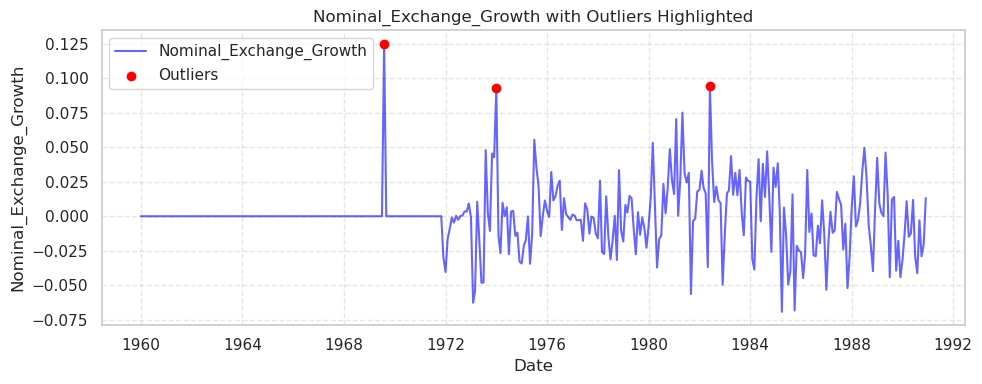

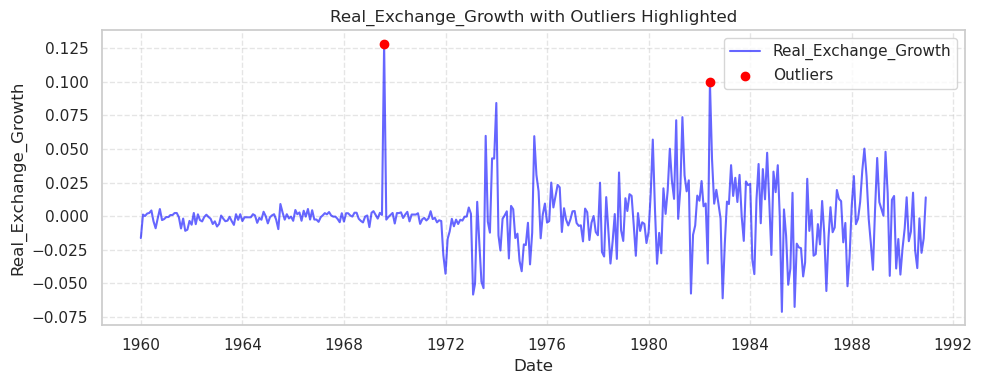

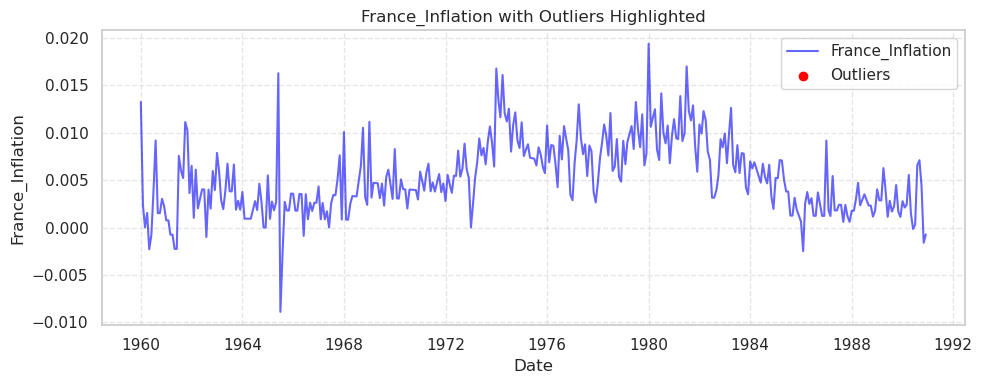

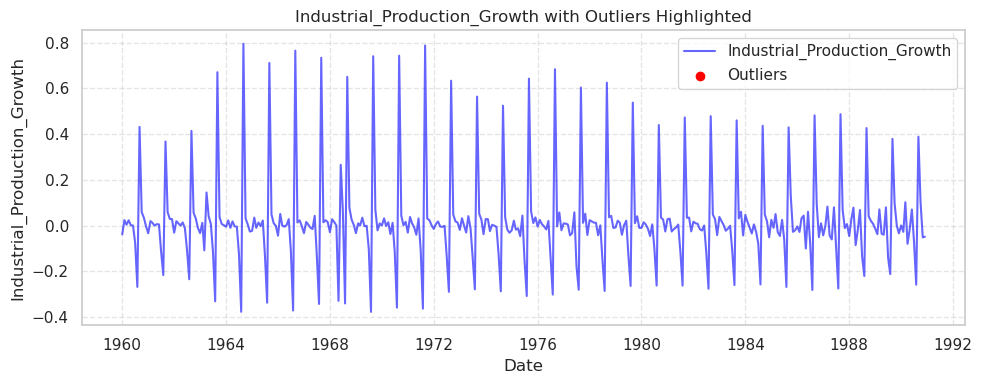

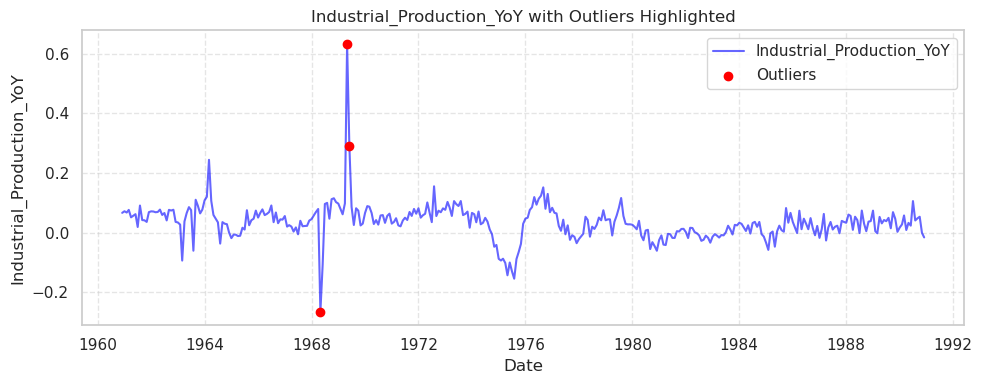

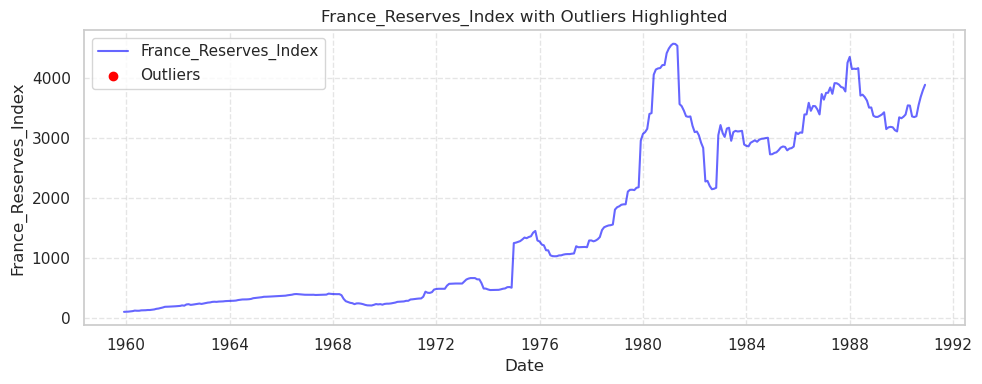

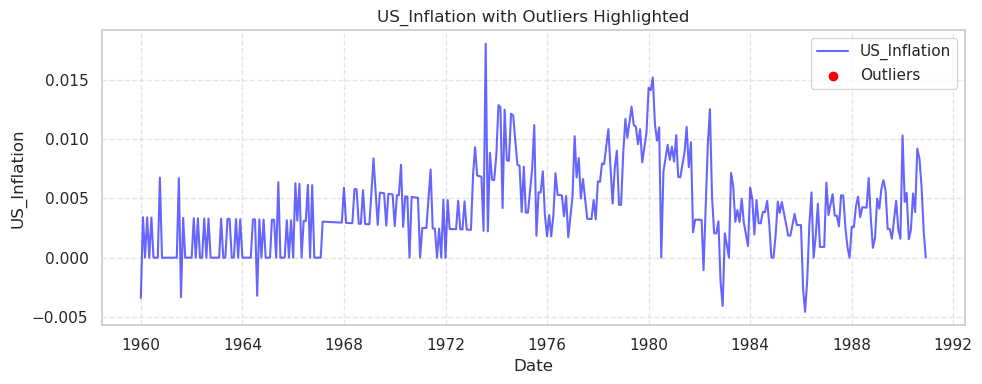

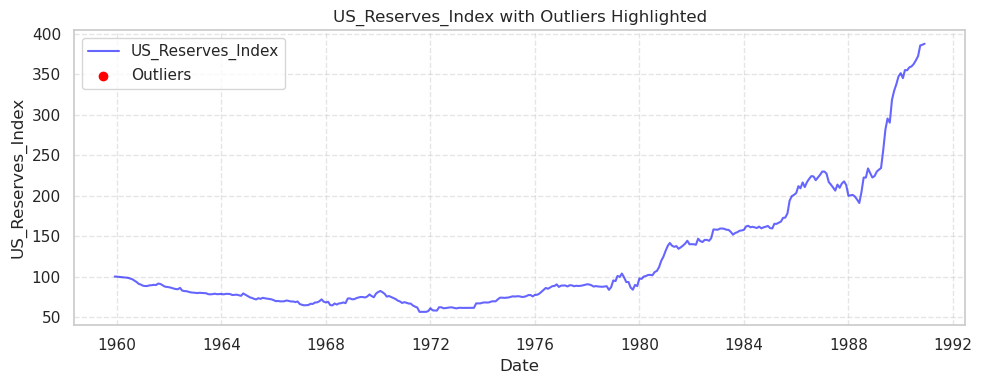

In [196]:
# Loop through each variable and plot time series with outliers marked
for var in outlier_vars:
    plt.figure(figsize=(10, 4))
    
    # Plot the full time series
    plt.plot(df["Date"], df[var], label=f"{var}", color="blue", alpha=0.6)
    
    # Highlight the outliers on top
    outlier_points = outliers_df[outliers_df["Variable"] == var]
    plt.scatter(outlier_points["Date"], outlier_points[var], color="red", label="Outliers", zorder=5)
    
    plt.title(f"{var} with Outliers Highlighted")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


- These graphs suggest that some of the outliers we found are outliers, except for Nominal_Exchange_Growth outliers in 1974-01-01 and 1982-06-01; Real_Exchange_Growth in 1982-06-01; and Industrial_Production_YoY in 1969-06-01 which seem to be in line with the volatility of the period. 
- Also, the outlier in 1969-08-01 in both Nominal and Real exchange rate growth is due to a change in the pegging of the Frank to the USD, therefore is not an outlier in data. 
From this, we will exclude the rest of the outliers found (2 in total).

In [197]:
outliers_long = outliers_df.melt(id_vars='Date', var_name='Variable', value_name='Value')


In [198]:
# Dates/variables you want to KEEP
keep_outliers = [
    ("1974-01-01", "Nominal_Exchange_Growth"),
    ("1969-08-01", "Nominal_Exchange_Growth"),
    ("1982-06-01", "Nominal_Exchange_Growth"),
    ("1982-06-01", "Real_Exchange_Growth"),
    ("1969-06-01", "Industrial_Production_YoY"),
    ("1969-08-01", "Real_Exchange_Growth")
]

# Filter out outliers you want to EXCLUDE
to_exclude = outliers_long[
    ~outliers_long[["Date", "Variable"]].apply(tuple, axis=1).isin(keep_outliers)
]

# Now set those specific outliers to NaN in the original df
for _, row in to_exclude.iterrows():
    df.loc[df["Date"] == row["Date"], row["Variable"]] = np.nan

# Optional: Interpolate
df.interpolate(method="linear", inplace=True)



### 4.2.4. Save the dataframe

In [199]:
# Set options to display all rows
pd.set_option("display.max_rows", None)

In [200]:
# Save cleaned and processed data
df.to_csv("../data/processed_data.csv", index=False)

print("Data processing complete. Cleaned data saved as 'processed_data.csv'")

df

Data processing complete. Cleaned data saved as 'processed_data.csv'


,Date,International_Reserves_US,CPI_Index_US,Industrial_Production_Index_France,Exchange_Rate_France,International_Reserves_France,CPI_Index_France,Nominal_Exchange_Growth,Real_Exchange_Rate,Real_Exchange_Growth,Real_Exchange_Index,France_Inflation,Industrial_Production_Growth,Industrial_Production_YoY,France_Reserves_Index,US_Inflation,US_Reserves_Index,Variable
0,1959-12-01,21504.500000,13.482806,35.365725,4.937060,1735.740000,10.208981,NaN,6.520281,NaN,NaN,NaN,NaN,NaN,98.973622,NaN,100.122916,NaN
1,1960-01-01,21478.100000,13.436946,33.997257,4.937060,1753.740000,10.344146,0.000000,6.413193,-0.016424,-1.179799,0.013240,-0.038695,NaN,100.000000,-0.003401,100.000000,NaN
2,1960-02-01,21395.700000,13.482806,34.793828,4.937060,1796.740000,10.367998,0.000000,6.420277,0.001105,0.079350,0.002306,0.023430,NaN,102.451903,0.003413,99.616353,NaN
3,1960-03-01,21344.700000,13.482806,34.916378,4.937060,1869.760000,10.367998,0.000000,6.420277,0.000000,0.000000,0.000000,0.003522,NaN,106.615576,0.000000,99.378902,NaN
4,1960-04-01,21278.000000,13.528666,35.712949,4.937060,1947.790000,10.383900,0.000000,6.432249,0.001865,0.133950,0.001534,0.022814,NaN,111.064924,0.003401,99.068353,NaN
5,1960-05-01,21234.300000,13.528666,35.743586,4.937060,2096.790000,10.360048,0.000000,6.447059,0.002302,0.165390,-0.002297,0.000858,NaN,119.561052,0.000000,98.864890,NaN
6,1960-06-01,21169.800000,13.574526,35.743586,4.937060,2057.790000,10.352096,0.000000,6.473882,0.004161,0.298870,-0.000767,0.000000,NaN,117.337234,0.003390,98.564584,NaN
7,1960-07-01,20999.400000,13.574526,33.016861,4.937060,2058.790000,10.391851,0.000000,6.449115,-0.003826,-0.274811,0.003840,-0.076286,NaN,117.394255,0.000000,97.771218,NaN
8,1960-08-01,20803.400000,13.574526,24.152452,4.937060,2168.790000,10.487262,0.000000,6.390443,-0.009098,-0.653535,0.009181,-0.268481,NaN,123.666564,0.000000,96.858661,NaN
9,1960-09-01,20430.000000,13.574526,34.569154,4.937060,2180.790000,10.503163,0.000000,6.380768,-0.001514,-0.108755,0.001516,0.431290,NaN,124.350816,0.000000,95.120146,NaN


In [201]:
# Uncomment if fully displayed tables become a bit much
# Reset display options to default
pd.reset_option("display.max_rows")

## 5.2. Analysis

### 5.2.1 Exchange Rate and International Reserve Graphs

Time series graphs:

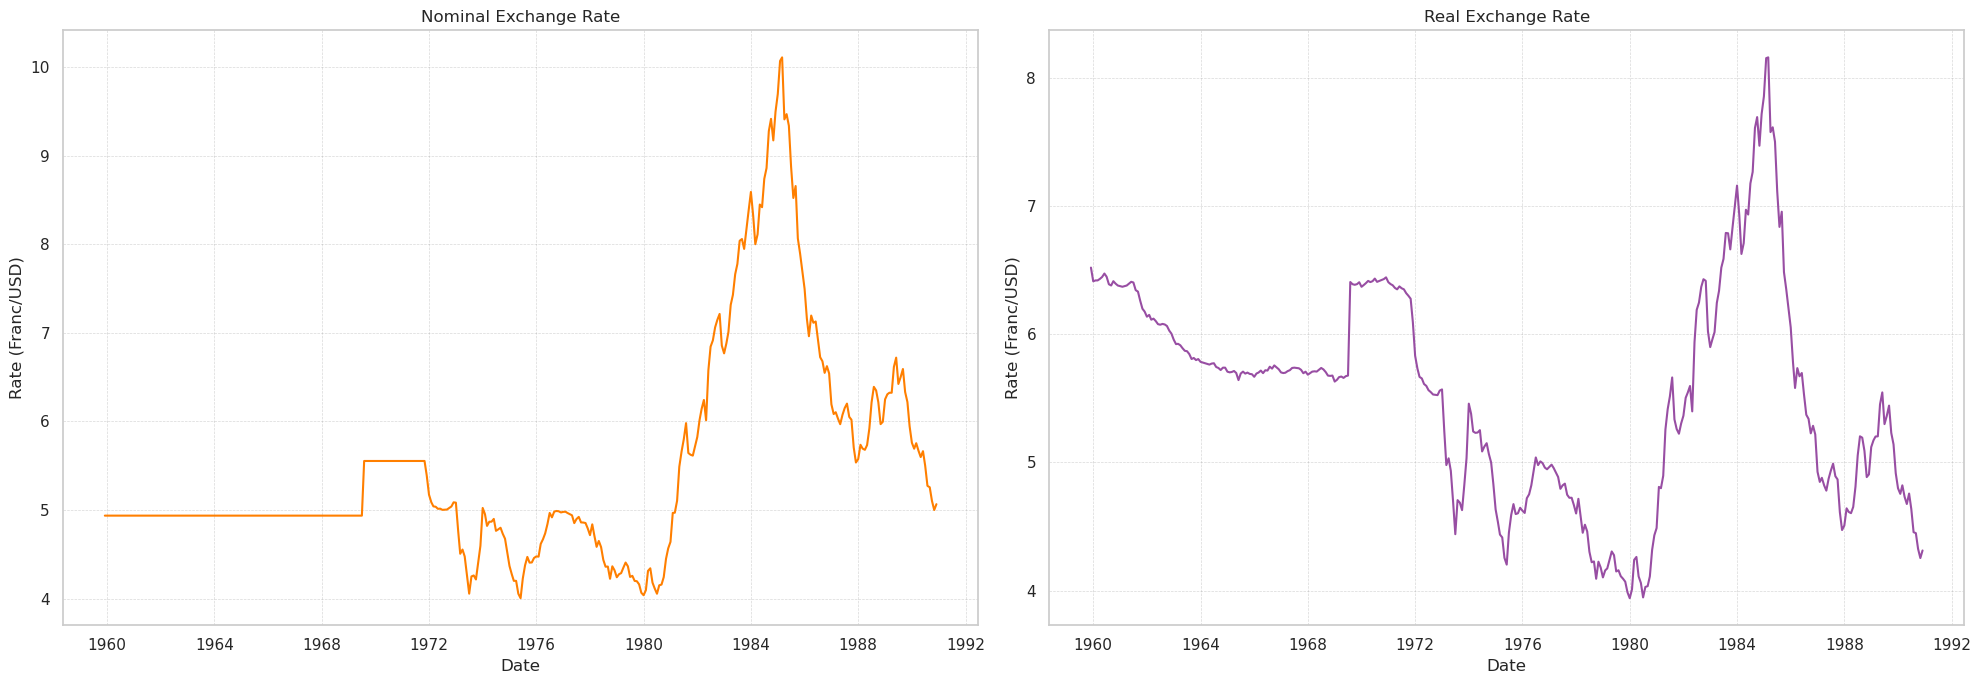

In [202]:
# Define colorblind-friendly colors (from Color Universal Design)
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#984ea3"]  

# Create a horizontal layout with 4 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharex=True)

# Plot each graph with clear labels, formatting, and gridlines

# 1. Level of the Nominal Exchange Rate
axes[0].plot(df["Date"], df["Exchange_Rate_France"], color=colors[1])
axes[0].set_title("Nominal Exchange Rate")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Rate (Franc/USD)")
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# 2. Real Exchange Rate
axes[1].plot(df["Date"], df["Real_Exchange_Rate"], color=colors[3])
axes[1].set_title("Real Exchange Rate")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rate (Franc/USD)")
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)  # Faint gridlines

# Improve spacing & formatting
plt.tight_layout()

# Save the figure
output_path = "../figures/exchange_rate_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the figure
plt.show()



Plot time series graphs of the monthly indexed value of international reserves for France and the
US from January 1960 until the exit of the US from Bretton Woods.

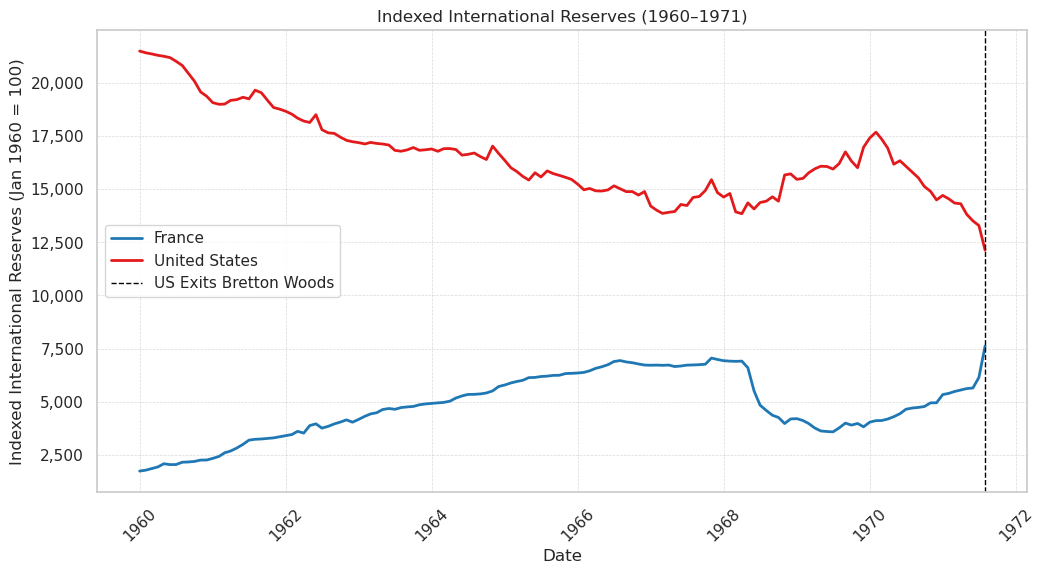

In [203]:
# Filter data from January 1960 to August 1971
df_filtered = df[(df["Date"] >= "1960-01") & (df["Date"] <= "1971-08")]

# Define visually appealing colors
colors = ["#1f78b4", "#e31a1c"]  # Deep blue for France, Deep red for the US

# Create figure
plt.figure(figsize=(12, 6))

# Plot indexed international reserves
plt.plot(df_filtered["Date"], df_filtered["International_Reserves_France"], label="France", color=colors[0], linewidth=2)
plt.plot(df_filtered["Date"], df_filtered["International_Reserves_US"], label="United States", color=colors[1], linewidth=2)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Indexed International Reserves (Jan 1960 = 100)")
plt.title("Indexed International Reserves (1960–1971)")

# Format y-axis with commas for thousands
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Grid, legend, and formatting
plt.axvline(pd.to_datetime("1971-08-01"), color="black", linestyle="--", linewidth=1, label="US Exits Bretton Woods")  # Mark the exit
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
plt.legend()

# Format x-axis dates for better readability
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Show every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Save the figure
output_path = "../figures/international_reserves_1960_1971.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


The US leaves the Bretton Woods system on 15th August 1971. This is shown by the vertical dashed line.

### 5.2.2. Inflation and Industrial Production Graphs 

**Time series graphs:**

Inflation Graphs: Monthly Inflation & Inflation Difference

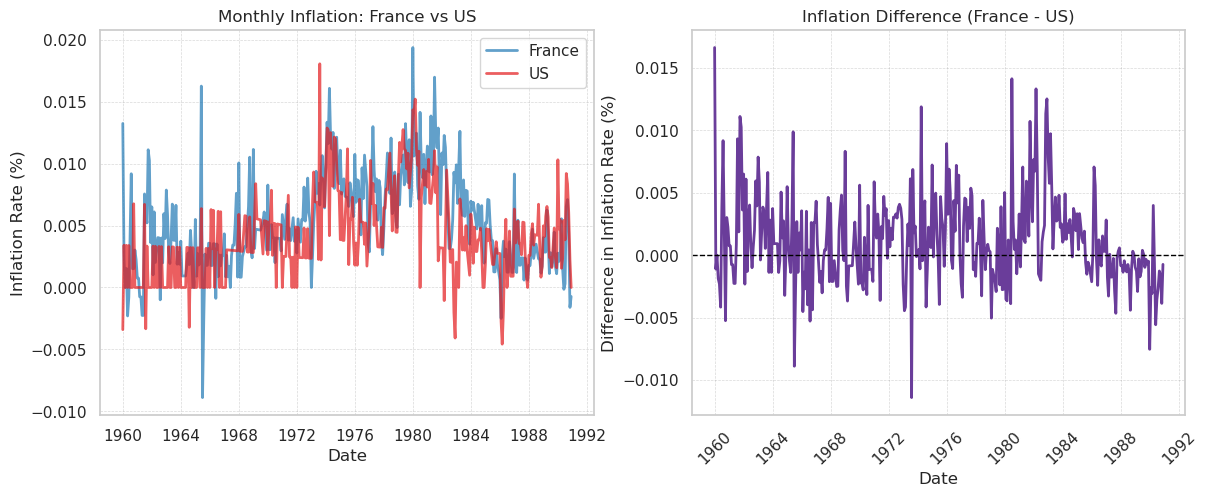

In [204]:
# Define colorblind-friendly colors
colors = ["#1f78b4", "#e31a1c", "#6a3d9a"]  # Blue (France), Red (US), Purple (Difference)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# 1. Combined Inflation (France vs US) with Transparency
axes[0].plot(df["Date"], df["France_Inflation"], color=colors[0], linewidth=2, alpha=0.7, label="France")
axes[0].plot(df["Date"], df["US_Inflation"], color=colors[1], linewidth=2, alpha=0.7, label="US")
axes[0].set_title("Monthly Inflation: France vs US")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate (%)")
axes[0].legend()
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Inflation Difference (France - US)
axes[1].plot(df["Date"], df["France_Inflation"] - df["US_Inflation"], color=colors[2], linewidth=2)
axes[1].set_title("Inflation Difference (France - US)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Difference in Inflation Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)  # Reference line at 0
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/inflation_graphs_combined.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()



Industrial Production:

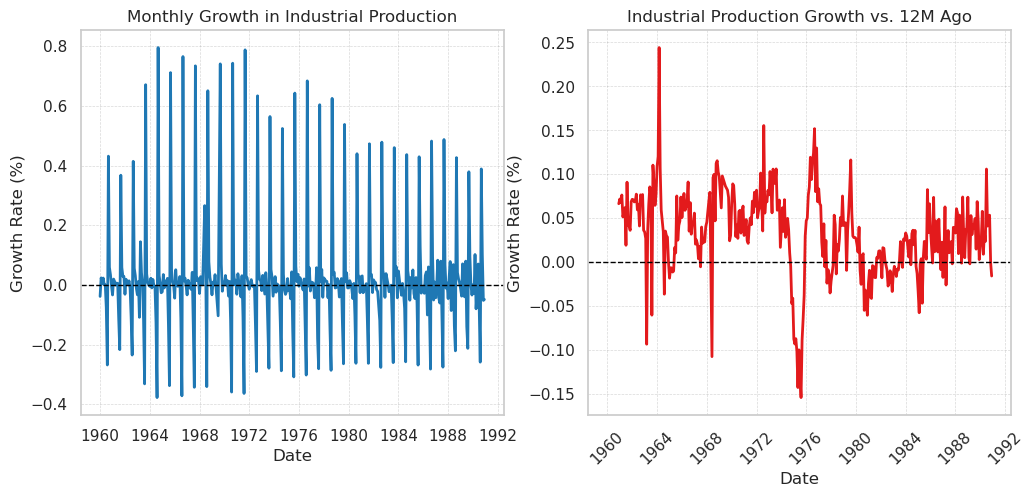

In [205]:
# Create figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# 1. Monthly Growth in Industrial Production
axes[0].plot(df["Date"], df["Industrial_Production_Growth"], color=colors[0], linewidth=2)
axes[0].set_title("Monthly Growth in Industrial Production")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Growth Rate (%)")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Growth in Industrial Production vs. 12 Months Ago
axes[1].plot(df["Date"], df["Industrial_Production_YoY"], color=colors[1], linewidth=2)
axes[1].set_title("Industrial Production Growth vs. 12M Ago")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Growth Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/industrial_production_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()




### 5.2.3. Comparison Statistics & Visualisation

Define Inflation Difference:

In [206]:
# Ensure Inflation Difference is in the dataset
df["Inflation_Difference"] = df["France_Inflation"] - df["US_Inflation"]

Calculations:

In [207]:
# Define periods
before_bw = df[df["Date"] <= "1971-06"]
after_bw = df[df["Date"] >= "1973-03"]

# Variables to analyse
std_vars = [
    "Nominal_Exchange_Growth",
    "Real_Exchange_Growth",
    "France_Inflation",
    "Inflation_Difference",
    "Industrial_Production_YoY"
]

# Compute standard deviations
std_before = before_bw[std_vars].std()
std_after = after_bw[std_vars].std()

# Compute ratio
std_ratio = std_before / std_after

# Create formatted table
std_table = pd.DataFrame({
    "Before Bretton Woods (≤ 06/1971)": std_before,
    "After Bretton Woods (≥ 03/1973)": std_after,
    "Ratio (Before / After)": std_ratio
}).reset_index(names="Variable")

Creating a summary table:

In [208]:
styled_table = std_table.style.background_gradient(
    subset=["Before Bretton Woods (≤ 06/1971)", "After Bretton Woods (≥ 03/1973)", "Ratio (Before / After)"],
    cmap="coolwarm" 
).set_caption("Standard Deviations Before and After Bretton Woods")

display(styled_table)

,Variable,Before Bretton Woods (≤ 06/1971),After Bretton Woods (≥ 03/1973),Ratio (Before / After)
0,Nominal_Exchange_Growth,0.000000,0.026292,0.000000
1,Real_Exchange_Growth,0.003665,0.026415,0.138738
2,France_Inflation,0.003130,0.003818,0.819961
3,Inflation_Difference,0.003688,0.003654,1.009521
4,Industrial_Production_YoY,0.041605,0.046966,0.885844


Creating the chart:

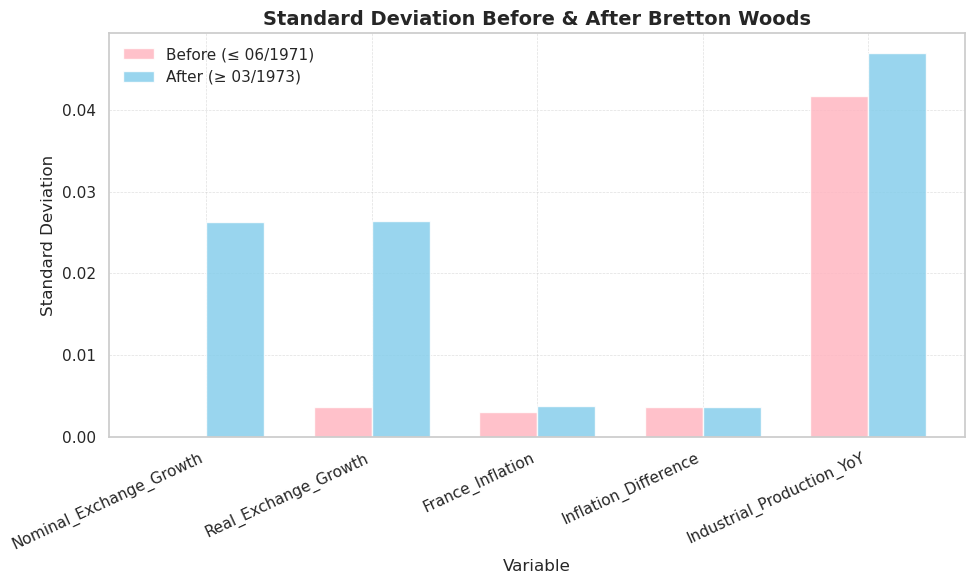

In [209]:
# Set theme & colors
sns.set_theme(style="whitegrid")
colors = ["#FFB6C1", "#87CEEB"]  
# Data Preparation
x_labels = std_table["Variable"]
before = std_table["Before Bretton Woods (≤ 06/1971)"]
after = std_table["After Bretton Woods (≥ 03/1973)"]

x = np.arange(len(x_labels))  # Label positions
width = 0.35  # Bar width

# Create figure & axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot grouped bars
bars1 = ax.bar(x - width/2, before, width, color=colors[0], label="Before (≤ 06/1971)", alpha=0.85)
bars2 = ax.bar(x + width/2, after, width, color=colors[1], label="After (≥ 03/1973)", alpha=0.85)

# Formatting
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=25, ha="right")
ax.set_xlabel("Variable", fontsize=12)
ax.set_ylabel("Standard Deviation", fontsize=12)
ax.set_title("Standard Deviation Before & After Bretton Woods", fontsize=14, fontweight="bold")

# Add gridlines and legend
ax.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.6)
ax.legend(loc="upper left", frameon=False)
plt.tight_layout()

# Save the chart
plt.savefig("../figures/std_dev_comparison.png", dpi=300)

# Display the chart
plt.show()


Plot the yearly standard deviation of the variable over time:

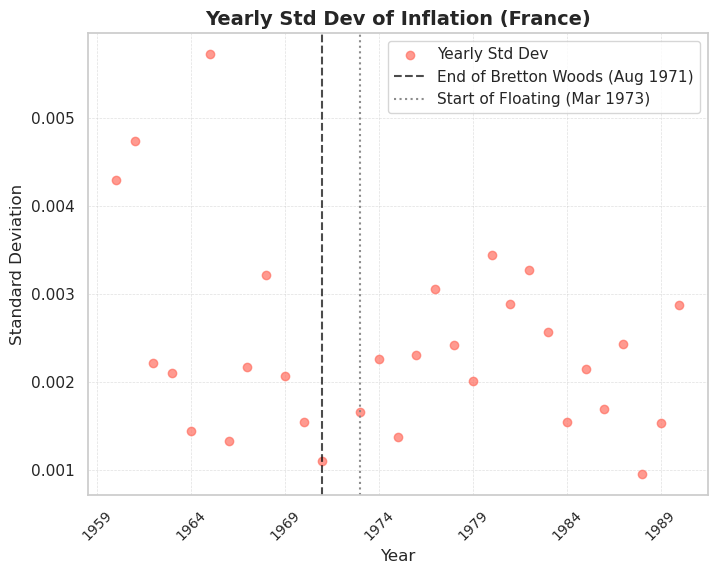

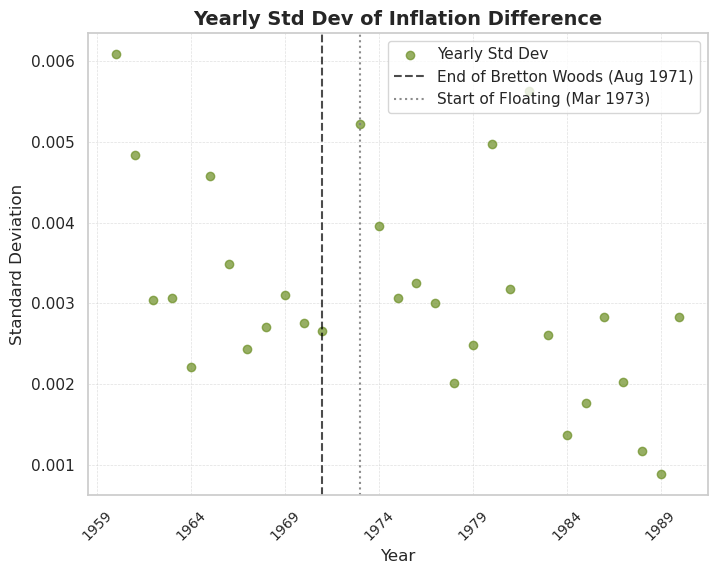

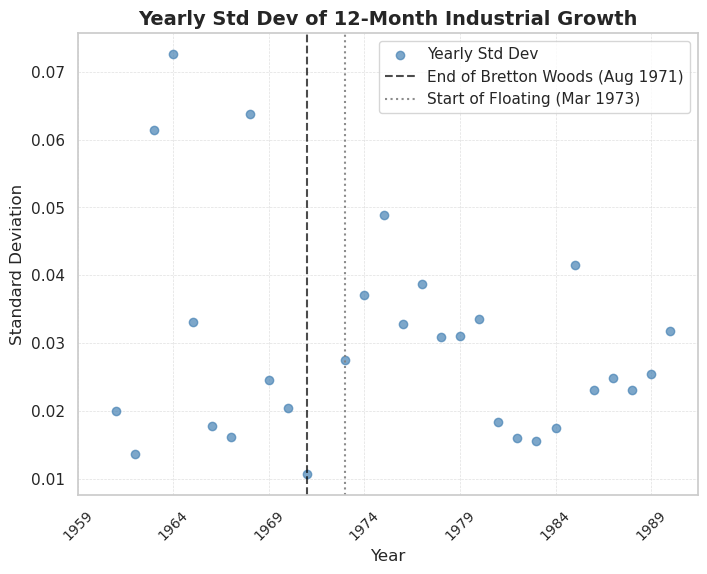

In [210]:
# Define pre/post Bretton Woods periods
pre_bretton_woods_end = "1971-08"
post_bretton_woods_start = "1973-03"

# Filter out data from 07/1971 - 02/1973
df_filtered = df[(df["Date"] <= pre_bretton_woods_end) | (df["Date"] >= post_bretton_woods_start)]
df_filtered["Year"] = df_filtered["Date"].dt.year  # Extract year

# Compute yearly standard deviations
yearly_std = df_filtered.groupby("Year")[["France_Inflation", "Inflation_Difference", "Industrial_Production_YoY"]].std()

# Set up colors & x-axis ticks
colors = {"France_Inflation": "#FF6F61", "Inflation_Difference": "#6B8E23", "Industrial_Production_YoY": "#4682B4"}
x_ticks = np.arange(yearly_std.index.min(), yearly_std.index.max() + 1, 5)

# Function to plot and save each graph
def plot_scatter(variable, title, filename, color):
    plt.figure(figsize=(8, 6))
    sns.set_theme(style="whitegrid")

    # Scatter plot
    plt.scatter(yearly_std.index, yearly_std[variable], color=color, alpha=0.7, label="Yearly Std Dev")
    
    # Add vertical lines for Bretton Woods transition
    plt.axvline(x=1971, color="black", linestyle="dashed", alpha=0.7, label="End of Bretton Woods (Aug 1971)")
    plt.axvline(x=1973, color="gray", linestyle="dotted", alpha=0.9, label="Start of Floating (Mar 1973)")

    # Formatting
    plt.title(title, fontsize=14, fontweight="bold")
    plt.ylabel("Standard Deviation", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.xticks(x_ticks, rotation=45, fontsize=10) 
    plt.grid(True, linestyle="dashed", linewidth=0.5, alpha=0.6)
    plt.legend()

    # Save figure
    plt.savefig(f"../figures/{filename}.png", dpi=300)
    plt.show()

# Generate & save all three plots
plot_scatter("France_Inflation", "Yearly Std Dev of Inflation (France)", "yearly_std_dev_inflation_france", colors["France_Inflation"])
plot_scatter("Inflation_Difference", "Yearly Std Dev of Inflation Difference", "yearly_std_dev_inflation_diff", colors["Inflation_Difference"])
plot_scatter("Industrial_Production_YoY", "Yearly Std Dev of 12-Month Industrial Growth", "yearly_std_dev_industrial", colors["Industrial_Production_YoY"])


### 5.2.4. Regression Analysis

Calculating standard deviation

In [211]:
# Remove rows from 1959
df = df[df["Date"].dt.year > 1959]

# Extract year and half-year indicator
df["Year"] = df["Date"].dt.year
df["Half"] = np.where(df["Date"].dt.month <= 6, "H1", "H2")

# Group by year and half-year and compute standard deviations
six_monthly_std_dev = df.groupby(["Year", "Half"]).agg({
    "Real_Exchange_Growth": "std",
    "Inflation_Difference": "std",
    "Industrial_Production_Growth": "std"
}).reset_index()

# Rename columns for clarity
six_monthly_std_dev.rename(columns={
    "Real_Exchange_Growth": "Real_Exchange_Growth_Std",
    "Inflation_Difference": "Inflation_Difference_Std",
    "Industrial_Production_Growth": "Industrial_Production_Growth_Std"
}, inplace=True)

# Save the DataFrame as a CSV file
six_monthly_std_dev.to_csv("../data/six_monthly_std_dev.csv", index=True)

# Display results
six_monthly_std_dev

,Year,Half,Real_Exchange_Growth_Std,Inflation_Difference_Std,Industrial_Production_Growth_Std
0,1960,H1,0.007601,0.007688,0.022610
1,1960,H2,0.004612,0.004640,0.229506
2,1961,H1,0.001348,0.001346,0.018496
3,1961,H2,0.004525,0.004573,0.198059
4,1962,H1,0.003699,0.003717,0.018721
...,...,...,...,...,...
57,1988,H2,0.032722,0.001700,0.222821
58,1989,H1,0.020076,0.000877,0.056063
59,1989,H2,0.027534,0.000505,0.208602
60,1990,H1,0.017176,0.003998,0.066917


We manually checked 2x 6 month periods chosen using a random number generator.

**Regression analysis**

In [212]:
# Define the independent variable (real exchange rate standard deviation)
X = six_monthly_std_dev["Real_Exchange_Growth_Std"]
X = sm.add_constant(X)  # Adds an intercept to the model

# Regression 1: Inflation difference standard deviation
y1 = six_monthly_std_dev["Inflation_Difference_Std"]
model1 = sm.OLS(y1, X).fit()
print("Regression Results: Inflation Difference Standard Deviation")
print(model1.summary())

# Regression 2: 12-monthly industrial production growth standard deviation
y2 = six_monthly_std_dev["Industrial_Production_Growth_Std"]
model2 = sm.OLS(y2, X).fit()
print("\nRegression Results: Industrial Production Growth Standard Deviation")
print(model2.summary())


Regression Results: Inflation Difference Standard Deviation
                               OLS Regression Results                               
Dep. Variable:     Inflation_Difference_Std   R-squared:                       0.000
Model:                                  OLS   Adj. R-squared:                 -0.017
Method:                       Least Squares   F-statistic:                  0.007901
Date:                      Mon, 24 Mar 2025   Prob (F-statistic):              0.929
Time:                              12:21:55   Log-Likelihood:                 314.58
No. Observations:                        62   AIC:                            -625.2
Df Residuals:                            60   BIC:                            -620.9
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.97

**Side by side graphs:**

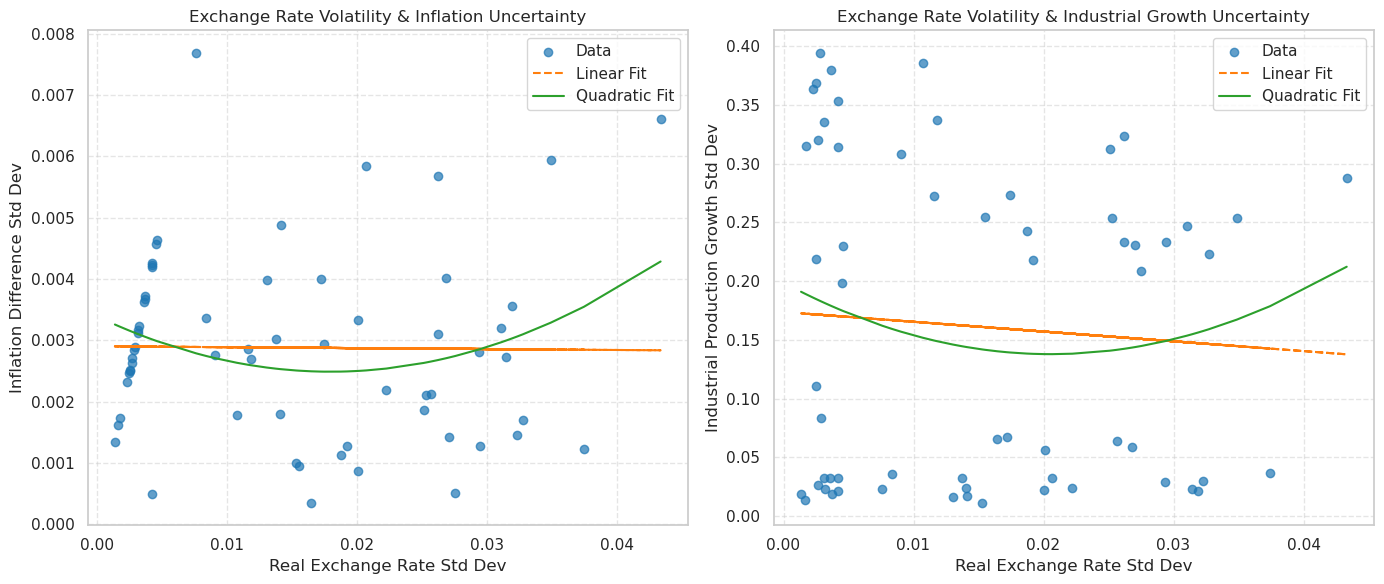

In [213]:
# Define independent variable
X = six_monthly_std_dev["Real_Exchange_Growth_Std"]

# Define dependent variables
y1 = six_monthly_std_dev["Inflation_Difference_Std"]
y2 = six_monthly_std_dev["Industrial_Production_Growth_Std"]

# Create figure with 2 side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Define colors
scatter_color = "#1f77b4"  # Blue for scatter points
linear_color = "#ff7f0e"   # Orange for linear fit
quadratic_color = "#2ca02c"  # Green for quadratic fit

# Function to add regression lines
def add_regression_lines(ax, X, y):
    # Scatter plot
    ax.scatter(X, y, color=scatter_color, alpha=0.7, label="Data")

    # Linear regression
    X_lin = sm.add_constant(X)
    lin_model = sm.OLS(y, X_lin).fit()
    ax.plot(X, lin_model.predict(X_lin), color=linear_color, linestyle="--", label="Linear Fit")

    # Quadratic regression
    X_quad = np.column_stack((X, X**2))
    X_quad = sm.add_constant(X_quad)
    quad_model = sm.OLS(y, X_quad).fit()
    X_sorted = np.sort(X)
    quad_pred = quad_model.predict(sm.add_constant(np.column_stack((X_sorted, X_sorted**2))))
    ax.plot(X_sorted, quad_pred, color=quadratic_color, linestyle="-", label="Quadratic Fit")

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

# Plot Inflation Difference vs. Real Exchange Rate Std Dev
add_regression_lines(axes[0], X, y1)
axes[0].set_title("Exchange Rate Volatility & Inflation Uncertainty")
axes[0].set_xlabel("Real Exchange Rate Std Dev")
axes[0].set_ylabel("Inflation Difference Std Dev")

# Plot Industrial Production Growth Std Dev vs. Real Exchange Rate Std Dev
add_regression_lines(axes[1], X, y2)
axes[1].set_title("Exchange Rate Volatility & Industrial Growth Uncertainty")
axes[1].set_xlabel("Real Exchange Rate Std Dev")
axes[1].set_ylabel("Industrial Production Growth Std Dev")

plt.tight_layout()
plt.show()

# Save the figure
fig.savefig("../figures/exchange_rate_volatility_vs_uncertainty.png", dpi=300, bbox_inches="tight")




## 6.1. Studying levels vs volatility

Amending earlier graphs to illustrate the end of Bretton Woods:

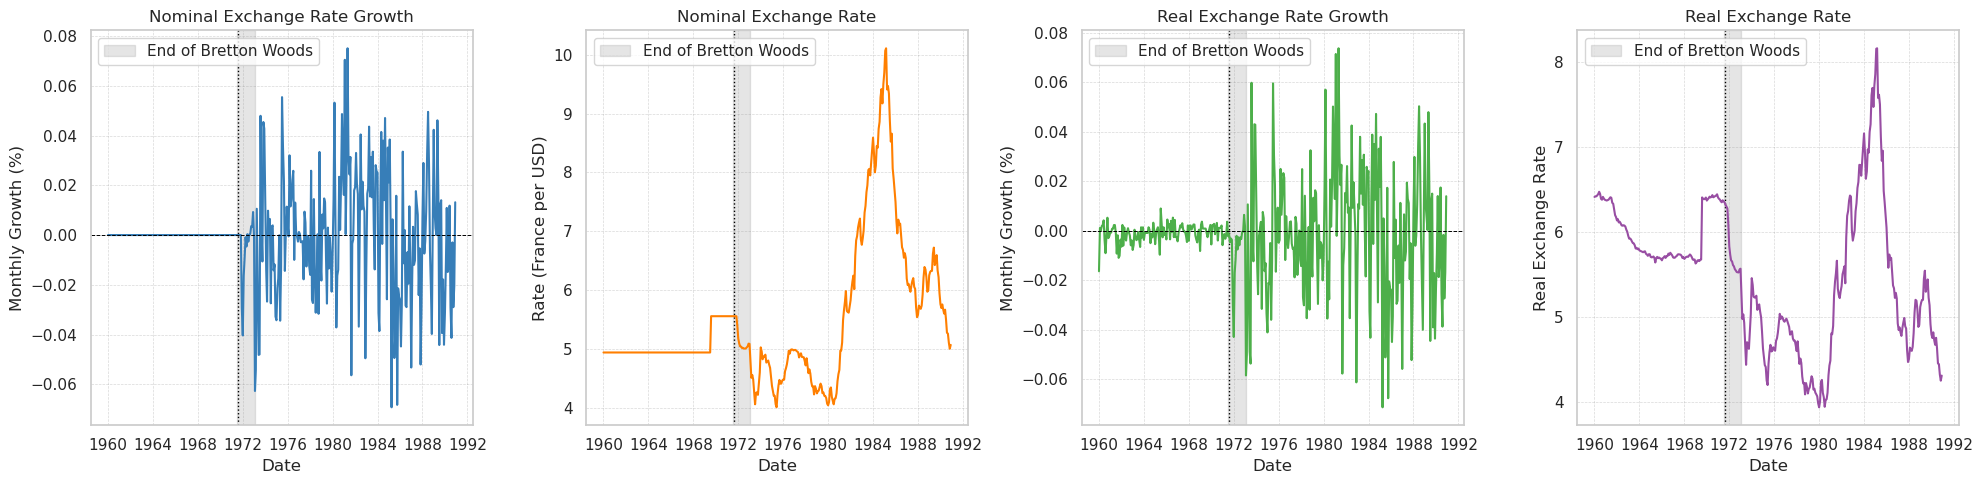

In [214]:
# Define colorblind-friendly colors (from Color Universal Design)
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#984ea3"]  

# Define dates for Bretton Woods and transitional period
bretton_woods_end = pd.Timestamp("1971-08-15")
transition_start = pd.Timestamp("1971-07-01")
transition_end = pd.Timestamp("1973-02-01")

# Create a horizontal layout with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

for ax in axes:
    # Greyed-out shaded area (faint)
    ax.axvspan(transition_start, transition_end, color="grey", alpha=0.2)
    # Vertical dotted line for end of Bretton Woods
    ax.axvline(bretton_woods_end, color="black", linestyle=":", linewidth=1)

# 1. Monthly Growth in the Nominal Exchange Rate
axes[0].plot(df["Date"], df["Nominal_Exchange_Growth"], color=colors[0])
axes[0].set_title("Nominal Exchange Rate Growth")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Monthly Growth (%)")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=0.7)
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Level of the Nominal Exchange Rate
axes[1].plot(df["Date"], df["Exchange_Rate_France"], color=colors[1])
axes[1].set_title("Nominal Exchange Rate")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Rate (France per USD)")
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 3. Monthly Growth in the Real Exchange Rate
axes[2].plot(df["Date"], df["Real_Exchange_Growth"], color=colors[2])
axes[2].set_title("Real Exchange Rate Growth")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Monthly Growth (%)")
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=0.7)
axes[2].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 4. Real Exchange Rate Index
axes[3].plot(df["Date"], df["Real_Exchange_Rate"], color=colors[3])
axes[3].set_title("Real Exchange Rate")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Real Exchange Rate")
axes[3].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Add legend
axes[0].legend(["End of Bretton Woods"], loc="upper left")
axes[1].legend(["End of Bretton Woods"], loc="upper left")
axes[2].legend(["End of Bretton Woods"], loc="upper left")
axes[3].legend(["End of Bretton Woods"], loc="upper left")

# Improve spacing & formatting
plt.tight_layout()

# Save the figure
output_path = "../figures/exchange_rate_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the figure
plt.show()



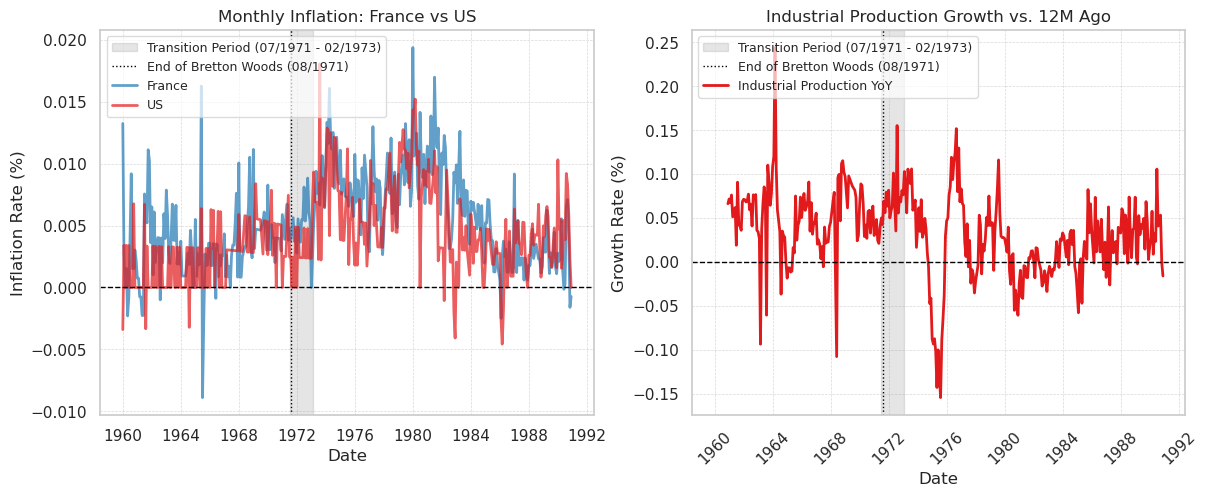

In [215]:
# Define colorblind-friendly colors
colors = ["#1f78b4", "#e31a1c", "#6a3d9a"] 

# Define dates for Bretton Woods and transitional period
bretton_woods_end = pd.Timestamp("1971-08-01")
transition_start = pd.Timestamp("1971-07-01")
transition_end = pd.Timestamp("1973-02-01")

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for ax in axes:
    # Greyed-out shaded area (faint)
    ax.axvspan(transition_start, transition_end, color="grey", alpha=0.2, label="Transition Period (07/1971 - 02/1973)")
    # Vertical dotted line for end of Bretton Woods
    ax.axvline(bretton_woods_end, color="black", linestyle=":", linewidth=1, label="End of Bretton Woods (08/1971)")

# 1. Inflation (France vs US) with transparency
axes[0].plot(df["Date"], df["France_Inflation"], color=colors[0], linewidth=2, alpha=0.7, label="France")
axes[0].plot(df["Date"], df["US_Inflation"], color=colors[1], linewidth=2, alpha=0.7, label="US")
axes[0].set_title("Monthly Inflation: France vs US")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Inflation Rate (%)")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].legend(loc="upper left", fontsize=9, framealpha=0.7)
axes[0].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# 2. Growth in Industrial Production vs. 12 Months Ago
axes[1].plot(df["Date"], df["Industrial_Production_YoY"], color=colors[1], linewidth=2, label="Industrial Production YoY")
axes[1].set_title("Industrial Production Growth vs. 12M Ago")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Growth Rate (%)")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].legend(loc="upper left", fontsize=9, framealpha=0.7)
axes[1].grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Save the figure
output_path = "../figures/inflation_and_production_graphs.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## 6.2. Black Wednesday: The UK Joining & Leaving the ERM

### 6.2.1. Cleaning the data 

In [216]:
#inserting new data
uk_url = "https://www.dropbox.com/scl/fi/688bg45628gmzyl01qq4n/International_Financial_Statistics_-4.xlsx?rlkey=kif0q32fb72tthzttvyr6df5c&st=6u57dr6z&dl=1"
germany_url = "https://www.dropbox.com/scl/fi/lfgqr6tbp5wsqsypvgtmk/International_Financial_Statistics_-5.xlsx?rlkey=c6un41zw0xhscol655pqzi74q&st=cx0d60j2&dl=1"

In [217]:
# Read the Excel files without headers
ukdf = pd.read_excel(uk_url, header=1)
gerdf = pd.read_excel(germany_url, header=1)

# Set the second column (Indicators) as index, remove the first column (Country name)
ukdf = ukdf.set_index(ukdf.columns[1]).drop(columns=ukdf.columns[0])
gerdf = gerdf.set_index(gerdf.columns[1]).drop(columns=gerdf.columns[0])

# Transpose the dataset
ukdf = ukdf.T
gerdf = gerdf.T

# Convert index to datetime to maintain chronological order
ukdf.index = pd.to_datetime(ukdf.index, format="%b %Y", errors="coerce")
gerdf.index = pd.to_datetime(gerdf.index, format="%b %Y", errors="coerce")

Renaming the variables:

In [218]:
rename_dict = {
    "Economic Activity, Industrial Production, Index": "Industrial_Production_Index",
    "Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate": "Exchange_Rate",
    "International Reserves and Liquidity, Reserves, Official Reserve Assets, US Dollar": "International_Reserves",
    "Prices, Consumer Price Index, All items, Index": "CPI_Index",
    "Monetary and Financial Accounts, Interest Rates, Central Bank Policy Rates, Monetary Policy-Related Interest Rate, Percent per Annum": "Interest_Rate"


}


ukdf.columns = [rename_dict.get(col, col) + "_UK" for col in ukdf.columns]
gerdf.columns = [rename_dict.get(col, col) + "_Germany" for col in gerdf.columns]

ukdf = ukdf.reset_index().rename(columns={"index": "Date"})
gerdf = gerdf.reset_index().rename(columns={"index": "Date"})

df1 = pd.merge(ukdf, gerdf, how="outer")

In [219]:
display(df1)

# save
df1.to_csv("../data/merged_data1.csv", index=False)

,Date,Industrial_Production_Index_UK,Exchange_Rate_UK,International_Reserves_UK,CPI_Index_UK,Industrial_Production_Index_Germany,Exchange_Rate_Germany,International_Reserves_Germany,CPI_Index_Germany
0,1980-01-01,71.962352,0.441725,23871.854784,31.325548,68.479065,1.7236,59544.209619,50.772433
1,1980-02-01,76.320897,0.436583,23932.608868,31.772502,68.687451,1.7472,56843.955234,51.401832
2,1980-03-01,76.970042,0.453360,26962.872281,32.206695,73.704761,1.8494,53350.775781,51.611640
3,1980-04-01,67.418338,0.451647,28700.559981,33.304938,69.681296,1.8728,56061.382325,51.891372
4,1980-05-01,66.861928,0.434432,28856.907553,33.611430,67.982143,1.7917,56035.380696,52.171115
...,...,...,...,...,...,...,...,...,...
260,2001-09-01,104.925838,0.683720,47758.247301,83.225448,90.076202,NaN,86590.642742,87.607304
261,2001-10-01,113.935177,0.689020,47386.197643,83.114481,94.490672,NaN,86153.409198,87.507294
262,2001-11-01,113.935177,0.696190,47480.978652,83.114481,95.016204,NaN,84971.411264,87.307274
263,2001-12-01,102.508698,0.694850,47417.467709,83.225448,80.721731,NaN,82131.887554,88.107343


Constructing variables:

In [220]:
# X Calculate DM/GBP exchange rate
df1["DM_GBP"] = df1["Exchange_Rate_Germany"] / df1["Exchange_Rate_UK"]

# X Calculate Monthly Growth in DM/GBP
df1["DM_GBP_Growth"] = df1["DM_GBP"].pct_change() * 100  # Convert to percentage

# Monthly Growth in the Nominal Exchange Rate (percentage change)
df1["Nominal_Exchange_Growth"] = df1["DM_GBP"].pct_change(fill_method=None) * 100

# X Monthly Growth in the Real Exchange Rate 
df1["Real_Exchange_Rate"] = (df1["DM_GBP"] * df1["CPI_Index_UK"]) / df1["CPI_Index_Germany"]
df1["Real_Exchange_Growth"] = df1["Real_Exchange_Rate"].pct_change(fill_method=None) * 100

#  X Real Exchange Rate Index (Set Oct 1990 = 1)
oct_1990_row = df1.loc[df1["Date"] == "1990-10-01", "Real_Exchange_Rate"]
if not oct_1990_row.empty:
    oct_1990_value = oct_1990_row.values[0]
else:
    oct_1990_value = df1["Real_Exchange_Rate"].iloc[0]  # Fallback to first available value

df1["Real_Exchange_Index"] = df1["Real_Exchange_Rate"] / oct_1990_value

# X Monthly Inflation Rate
df1["Inflation_UK"] = df1["CPI_Index_UK"].pct_change(fill_method=None) * 100
df1["Inflation_Germany"] = df1["CPI_Index_Germany"].pct_change(fill_method=None) * 100

#  Monthly Growth in Industrial Production
df1["Industrial_Production_Growth_UK"] = df1["Industrial_Production_Index_UK"].pct_change(fill_method=None) * 100
#df1["Industrial_Production_Growth_Germany"] = df1["Industrial_Production_Index_Germany"].pct_change(fill_method=None) * 100

# Growth in Industrial Production vs 12 Months Ago
#df1["Industrial_Production_YoY_UK"] = df1["Industrial_Production_Index_UK"].pct_change(periods=12, fill_method=None) * 100
#df1["Industrial_Production_YoY_Germany"] = df1["Industrial_Production_Index_Germany"].pct_change(periods=12, fill_method=None) * 100

# X International Reserves Index (Set Jan 1970 = 100)
jan_1980_row = df1.loc[df1["Date"] == "1980-01-01", "International_Reserves_UK"]
if not jan_1980_row.empty:
    jan_1980_value = jan_1980_row.values[0]
else:
    jan_1970_value = df1["International_Reserves_UK"].iloc[0]  # Fallback

df1["Reserves_Index_UK"] = (df1["International_Reserves_UK"] / jan_1980_value) * 100

jan_1980_row_germany = df1.loc[df1["Date"] == "1980-01-01", "International_Reserves_Germany"]
if not jan_1980_row_germany.empty:
    jan_1980_value_germany = jan_1980_row_germany.values[0]
else:
    jan_1980_value_germany = df1["International_Reserves_Germany"].iloc[0]  # Fallback

df1["Reserves_Index_Germany"] = (df1["International_Reserves_Germany"] / jan_1980_value_germany) * 100

# X Compute Inflation Difference
df1["Inflation_Diff"] = df1["Inflation_UK"] - df1["Inflation_Germany"]

# X Compute Rolling 6-Month Standard Deviations (Volatility)
df1["Volatility_Exchange_Growth"] = df1["DM_GBP_Growth"].rolling(6).std()
df1["Volatility_Inflation_Diff"] = df1["Inflation_Diff"].rolling(6).std()
df1["Volatility_Ind_Prod_Growth"] = df1["Industrial_Production_Growth_UK"].rolling(6).std()

# Save the processed dataset
df1.to_csv("../data/processed_data1.csv", index=False)


1. Why did the UK join the ERM?

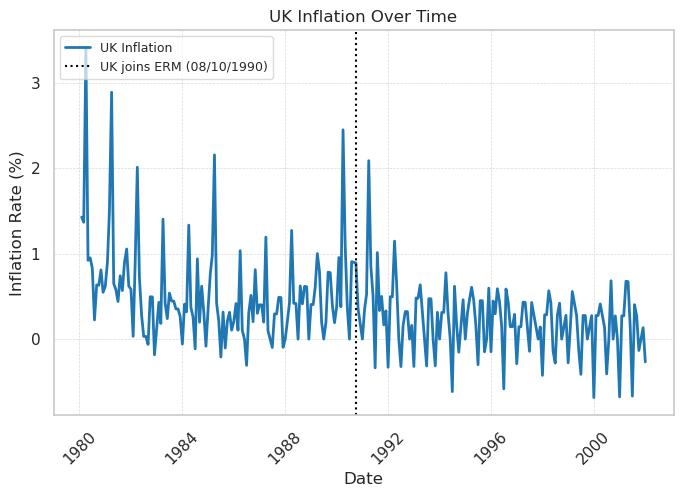

In [221]:
# Define colorblind-friendly color
color_uk = "#1f78b4"

# Define ERM entry date
erm_entry = pd.Timestamp("1990-10-08")

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(df1["Date"], df1["Inflation_UK"], color=color_uk, linewidth=2, label="UK Inflation")
plt.axvline(erm_entry, color="black", linestyle=":", linewidth=1.5, label="UK joins ERM (08/10/1990)")

# Labels and formatting
plt.title("UK Inflation Over Time")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend(loc="upper left", fontsize=9, framealpha=0.7)
plt.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.3)
plt.xticks(rotation=45)

# Save the figure
plt.savefig("../figures/uk_inflation_erm.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


2. What led to the currency attack on the pound?

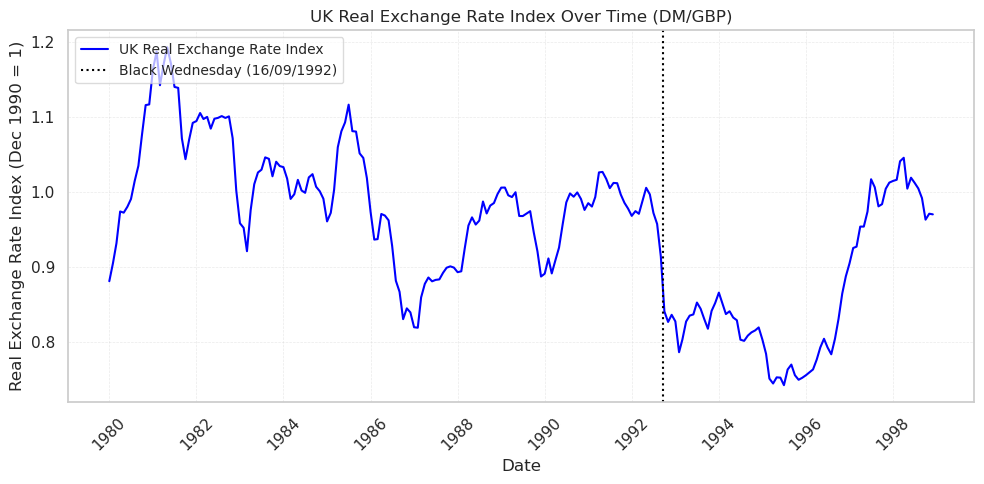

In [222]:
# Define date for Black Wednesday
black_wednesday = pd.Timestamp("1992-09-16")

# Plot Real Exchange Rate Index for the UK
plt.figure(figsize=(10, 5))
plt.plot(df1["Date"], df1["Real_Exchange_Index"], color="blue", label="UK Real Exchange Rate Index")

# Vertical dotted line for Black Wednesday
plt.axvline(black_wednesday, color="black", linestyle=":", linewidth=1.5, label="Black Wednesday (16/09/1992)")

# Title and labels
plt.title("UK Real Exchange Rate Index Over Time (DM/GBP)")
plt.xlabel("Date")
plt.ylabel("Real Exchange Rate Index (Dec 1990 = 1)")

# Grid and legend
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
plt.legend(loc="upper left", fontsize="small", framealpha=0.7)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Save or show
plt.tight_layout()
plt.savefig("../figures/UK_real_exchange_black_wednesday.png", dpi=300, bbox_inches="tight")
plt.show()

3. Did ERM & Black Wednesday impact exchange rate and macroeconomic volatility?

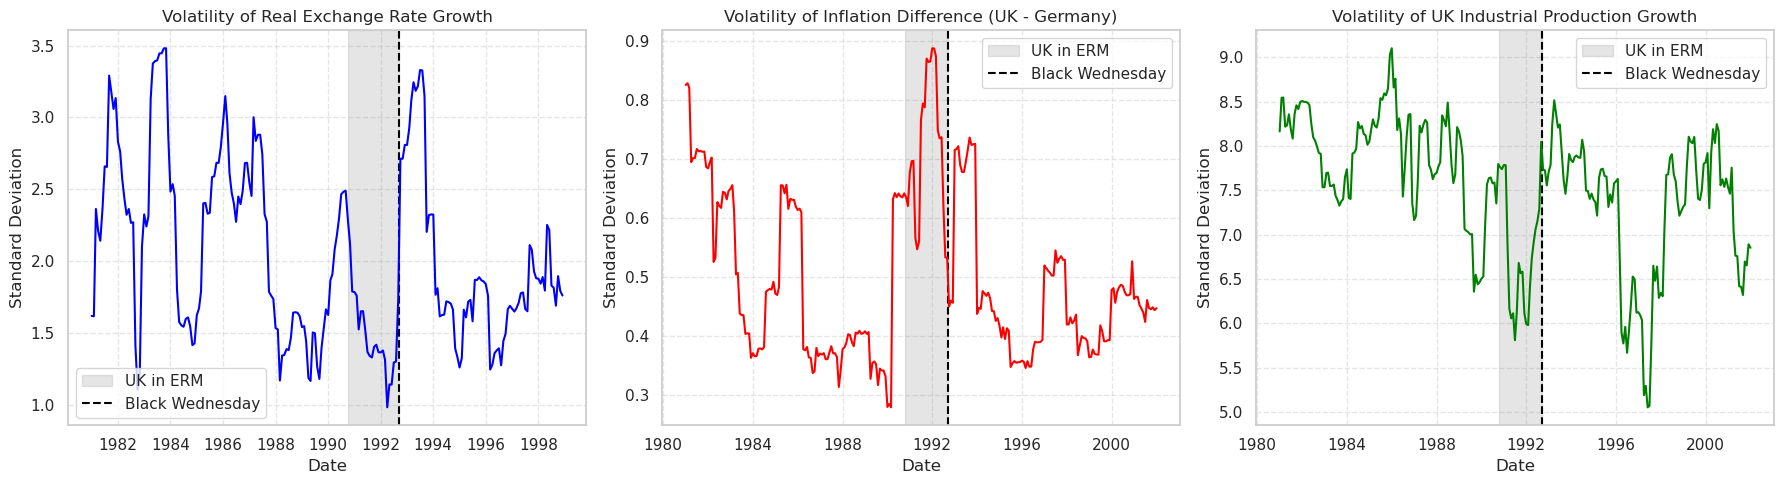

In [223]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Define ERM period
erm_start = pd.Timestamp("1990-10-08")
black_wednesday = pd.Timestamp("1992-09-16")

for ax in axes:
    # Greyed-out shaded area for ERM membership period
    ax.axvspan(erm_start, black_wednesday, color="grey", alpha=0.2, label="UK in ERM")
    # Vertical line for Black Wednesday
    ax.axvline(black_wednesday, color="black", linestyle="--", label="Black Wednesday")

# Real Exchange Rate Growth Volatility
axes[0].plot(df1["Date"], df1["Real_Exchange_Growth"].rolling(12).std(), color="blue")
axes[0].set_title("Volatility of Real Exchange Rate Growth")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Standard Deviation")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Inflation Difference Volatility
axes[1].plot(df1["Date"], df1["Inflation_Diff"].rolling(12).std(), color="red")
axes[1].set_title("Volatility of Inflation Difference (UK - Germany)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Standard Deviation")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# Industrial Production Growth Volatility
axes[2].plot(df1["Date"], df1["Industrial_Production_Growth_UK"].rolling(12).std(), color="green")
axes[2].set_title("Volatility of UK Industrial Production Growth")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Standard Deviation")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("../figures/Post_Black_Wednesday_Volatility.png")
plt.show()


4. How much did exchange rates change after Black Wednesday?

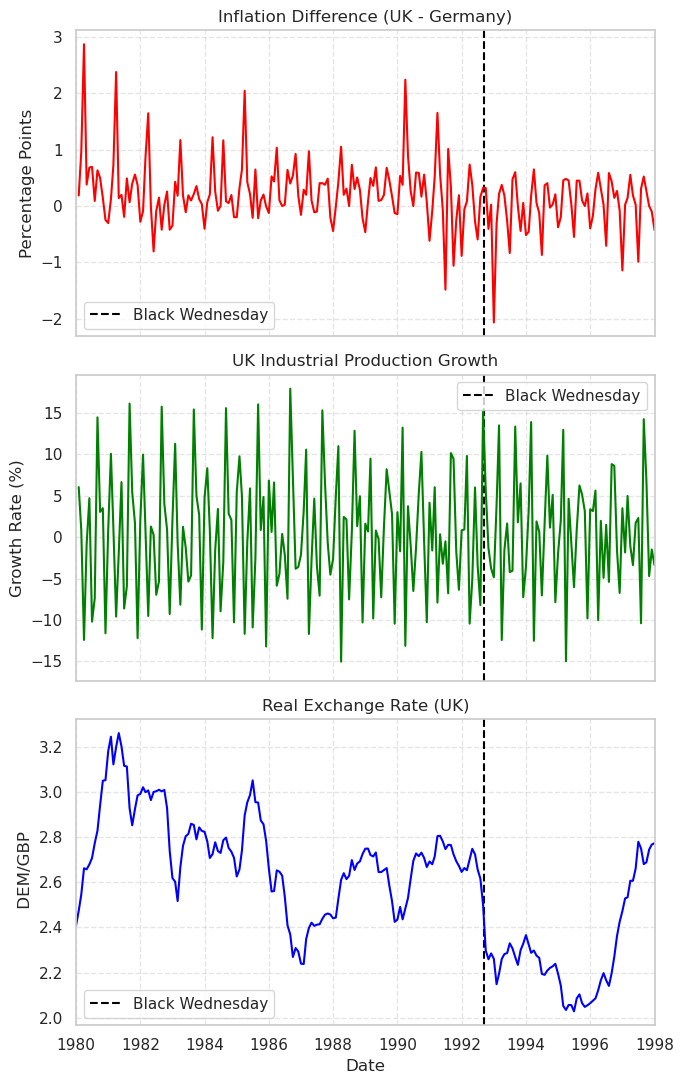

In [224]:
fig, axes = plt.subplots(3, 1, figsize=(7, 11), sharex=True)

# Define Black Wednesday date
black_wednesday = pd.Timestamp("1992-09-16")

# Define x-axis limit
end_date = pd.Timestamp("1998-01-01")

for ax in axes:
    ax.axvline(black_wednesday, color="black", linestyle="--", label="Black Wednesday")
    ax.set_xlim(df1["Date"].min(), end_date)  # Set x-axis from start to end of 2002

# 1. Inflation Difference (UK - Germany)
axes[0].plot(df1["Date"], df1["Inflation_Diff"], color="red")
axes[0].set_title("Inflation Difference (UK - Germany)")
axes[0].set_ylabel("Percentage Points")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# 2. Industrial Production Growth (UK)
axes[1].plot(df1["Date"], df1["Industrial_Production_Growth_UK"], color="green")
axes[1].set_title("UK Industrial Production Growth")
axes[1].set_ylabel("Growth Rate (%)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# 3. Real Exchange Rate (UK)
axes[2].plot(df1["Date"], df1["Real_Exchange_Rate"], color="blue")
axes[2].set_title("Real Exchange Rate (UK)")
axes[2].set_xlabel("Date")
axes[2].set_ylabel(" DEM/GBP")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("../figures/Inflation_Production_Exchange_Growth.png")
plt.show()
